# Wrongly combining rejection with sampling

##### Keywords: sampling,  MCMC, metropolis, rejection sampling, normalization, metropolis-hastings

From https://darrenjw.wordpress.com/2012/06/04/metropolis-hastings-mcmc-when-the-proposal-and-target-have-differing-support/

In [1]:
%matplotlib inline
import numpy as np
import scipy as  sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn.apionly as sns
sns.set_style("whitegrid")

As a simple example, lets target `Gamma(2,1)` or $xe^{-x}, x \gt 0$.

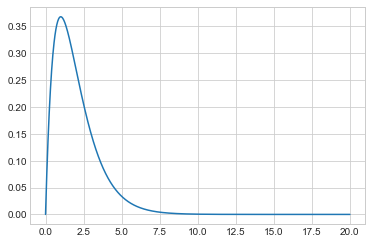

In [4]:
target = lambda x: x*np.exp(-x)
xx = np.linspace(0, 20, 1000)
plt.plot(xx, target(xx));

## Using Metropolis to sample

Here, copied from before, is the metropolis code.

In [5]:
def metropolis(p, qdraw, nsamp, xinit):
    samples=np.empty(nsamp)
    x_prev = xinit
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples[i] = x_star
            x_prev = x_star
        else:#we always get a sample
            samples[i]= x_prev
            
    return samples


In [7]:
def prop(x):
    return np.random.normal(x, 1.0)
out = metropolis(target, prop, 100000, 1.0)

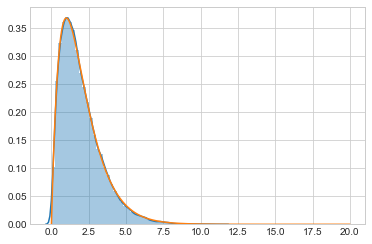

In [8]:
sns.distplot(out)
plt.plot(xx, target(xx));

Since we use the functional form directly without checking for $x \gt 0$, we are **not sampling on the correct support**. This does not land up costing us, as the acceptance ratio being negative the first time we sample a negative $x$ will ensure that we *never* sample a negative $x$. We would be better using `scipy.stats` built in gamma support.

We have seen this before, in sampling from a weibull using a normal as well. Also from sampling from a function only defined on [0,1]. Some people consider the lax use of a larger-support proposal a bug. But it does not bite us anywhere but efficiency due to the mechanism of the acceptance ratio.

Let us see what this lack of efficiency is:

In [12]:
def metropolis_instrument(p, qdraw, nsamp, xinit):
    samples=np.empty(nsamp)
    x_prev = xinit
    acc1 = 0
    rej_neg = 0
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples[i] = x_star
            x_prev = x_star
            acc1 += 1
        else:#we always get a sample
            if x_star < 0:
                rej_neg += 1
            samples[i]= x_prev
            
    return samples, acc1, rej_neg

In [13]:
out2, a1, rn = out = metropolis_instrument(target, prop, 100000, 1.0)

In [15]:
a1/100000, rn/(100000 - a1)

(0.7298, 0.3654700222057735)

Thus, out of a 73% acceptance, a full 36% is wasted on proposing negatives.

## A wrong built-in regection sampler

You might think that simply rejecting is ok, but you would be wrong. You are then sampling from some other distribution.

In [18]:
def metropolis_broken(p, qdraw, nsamp, xinit):
    samples=np.empty(nsamp)
    x_prev = xinit
    for i in range(nsamp):
        while 1:
            x_star = qdraw(x_prev)
            if x_star > 0:
                break
        
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples[i] = x_star
            x_prev = x_star
        else:#we always get a sample
            samples[i]= x_prev
            
    return samples



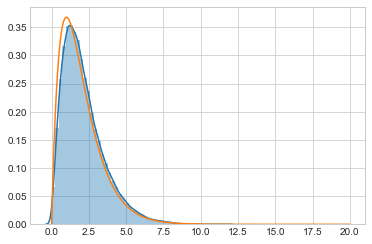

In [19]:
out3 = metropolis_broken(target, prop, 100000, 1.0)
sns.distplot(out3)
plt.plot(xx, target(xx));

## Fix using MH

To fix this use Metropolis-Hastings instead and sample from a distribution eith the correct support, a truncated normal. Since the truncated normal is not symmetric:

$$ \frac{e^{(x-x_0)^2}}{CDF(x)} != \frac{e^{(x_0-x)^2}}{CDF(x_0)} $$

we must use a MH Sampler

In [39]:
def metropolis_hastings(p,q, qdraw, nsamp, xinit):
    samples=np.empty(nsamp)
    x_prev = xinit
    accepted=0
    for i in range(nsamp):
        while 1:
            x_star = qdraw(x_prev)
            if x_star > 0:
                break
        
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        proposalratio = q(x_prev, x_star)/q(x_star, x_prev)
        if np.random.uniform() < min(1, pdfratio*proposalratio):
            samples[i] = x_star
            x_prev = x_star
            accepted +=1
        else:#we always get a sample
            samples[i]= x_prev
            
    return samples, accepted

In [48]:
from scipy.stats import norm
def prop2(x):
    return x + np.random.normal()
def q(x_prev, x_star):
    num = norm.cdf(x_prev)
    return num

In [49]:
out4, _ = metropolis_hastings(target, q, prop2, 100000, 1.0)

Now we get the correct output!

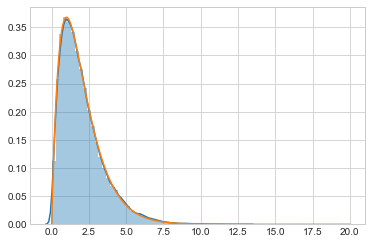

In [50]:
sns.distplot(out4)
plt.plot(xx, target(xx));